In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import sys
from tqdm import tqdm
import pathlib
from pathlib import Path
import contextlib
import io

In [2]:
import sys
sys.version

'3.12.6 (main, Sep  6 2024, 19:03:47) [Clang 15.0.0 (clang-1500.3.9.4)]'

In [3]:
# import gaps_online as go
import go_pybindings as go
import gaps_online.db as db

Can't load CXX API! No module named 'gaps_tof'


In [6]:
# run_id = 30198
# dataset = pathlib.Path(f'/Users/gracetytus/gaps/test_charge_data/{run_id}')
#files = [f for f in sorted(dataset.glob('*.tof.gaps'))]

run_path = Path('/Users/gracetytus/gaps/test_charge_data/30198')

files = np.array([str(f) for f in ((run_path.glob('*.tof.gaps')))])
f_nums = [int(file.split('.')[0].split('_')[-1]) for file in files]
files = files[np.argsort(f_nums)]

In [8]:
files[0].split('.')[0].split('_')[-1]
print(len(files))

263


In [ ]:
#depreciated

event_list = []
for f in files[:2]:
    reader = go.io.TofPacketReader(str(f), filter=go.io.PacketType.TofEvent)
    
    for k in tqdm.tqdm(reader):
        event = go.events.TofEvent()
        event.from_tofpacket(k)
        settings = go.liftof.LiftofSettings()
        settings = settings.from_file('/Users/gracetytus/gaps/test_charge_data/30141/run30141.toml')
    
        new_ev = go.liftof.waveform_analysis(event, settings)
        event_list.append(new_ev)

In [9]:
print(files[:10])

['/Users/gracetytus/gaps/test_charge_data/30198/Run30198_0.240816_044057UTC.tof.gaps'
 '/Users/gracetytus/gaps/test_charge_data/30198/Run30198_1.240816_044304UTC.tof.gaps'
 '/Users/gracetytus/gaps/test_charge_data/30198/Run30198_2.240816_044400UTC.tof.gaps'
 '/Users/gracetytus/gaps/test_charge_data/30198/Run30198_3.240816_044457UTC.tof.gaps'
 '/Users/gracetytus/gaps/test_charge_data/30198/Run30198_4.240816_044554UTC.tof.gaps'
 '/Users/gracetytus/gaps/test_charge_data/30198/Run30198_5.240816_044650UTC.tof.gaps'
 '/Users/gracetytus/gaps/test_charge_data/30198/Run30198_6.240816_044746UTC.tof.gaps'
 '/Users/gracetytus/gaps/test_charge_data/30198/Run30198_7.240816_044842UTC.tof.gaps'
 '/Users/gracetytus/gaps/test_charge_data/30198/Run30198_8.240816_044939UTC.tof.gaps'
 '/Users/gracetytus/gaps/test_charge_data/30198/Run30198_9.240816_045036UTC.tof.gaps']


In [ ]:
## multiple files

n_trigger_hits = 0
n_readout_hits = 0
npack          = 0
done           = False
evtbld_hb      = []
mtbmonis       = []

for file in files:
    reader = go.io.TofPacketReader(str(file))
    for pack in reader:
        npack += 1
        if pack.packet_type == go.io.PacketType.TofEvent:
            ev = go.events.TofEvent()
            try:
                ev.from_tofpacket(pack)
                n_readout_hits += len(ev.hits)
                n_trigger_hits += len(ev.mastertriggerevent.trigger_hits)
            except: continue 
    
        # heartbeat data is only stored in later runs
        elif pack.packet_type == go.io.PacketType.EVTBLDRHeartbeat:
            hb = go.commands.EVTBLDRHeartbeat()
            #hb = go.tof.monitoring.EVTBLDRHeartbeat()
            try: 
                hb.from_tofpacket(pack)
                evtbld_hb.append(hb)
            except: continue
    
        elif pack.packet_type == go.io.PacketType.MonitorMtb:
            #moni = go.tof.monitoring.MtbMoniData()
            moni = go.moni.MtbMoniData()
            try: 
                moni.from_tofpacket(pack)
                mtbmonis.append(moni)
            except: continue 

In [10]:
reader = go.io.TofPacketReader(str(files[0]))

In [ ]:
n_evt_packets = 0
n_heartbeat_packets = 0
n_monitor_packets = 0

reader = go.io.TofPacketReader(str(files[0]))
for packet in reader:
    if packet.packet_type == go.io.PacketType.TofEvent:
        n_evt_packets += 1
        event = go.events.TofEvent()
    elif packet.packet_type == go.io.PacketType.EVTBLDRHeartbeat:
        n_heartbeat_packets += 1
        heartbeat = go.commands.EVTBLDRHeartbeat()
        #heartbeat.from_tofpacket(packet)
    elif packet.packet_type == go.io.PacketType.MonitorMtb:
        n_monitor_packets += 1
        monitor = go.moni.MtbMoniData()
        monitor.from_tofpacket(packet)

In [ ]:
n_heartbeat_packets

In [ ]:
n_evt_packets

In [ ]:
n_monitor_packets

In [12]:
evtbld_hb      = []

with contextlib.redirect_stderr(io.StringIO()):
    for f in tqdm(files, desc="Processing files", unit="file", file=sys.stdout):

        reader = go.io.TofPacketReader(str(f))
        for pack in reader:
            
        
            # heartbeat data is only stored in later runs
            if pack.packet_type == go.io.PacketType.MTBHeartbeat:
                hb = go.commands.MTBHeartbeat()
                #hb = go.tof.monitoring.EVTBLDRHeartbeat()
                try: 
                    hb.from_tofpacket(pack)
                    evtbld_hb.append(hb)
                except: continue
        

Processing files:  17%|██████████████████▏                                                                                          | 44/263 [00:09<00:47,  4.60file/s]


KeyboardInterrupt: 

In [30]:
percent_hg_discarded = []
met_from_hb = []

for hb in evtbld_hb:
    rb_disc = hb.n_rbe_discarded_tot
    rb_rec = hb.n_rbe_received_tot
    trate = hb.
    
    if rb_rec != 0:
        percent_disc = (rb_disc / rb_rec) * 100
        percent_disc = round(percent_disc, 1)
        if percent_disc != 100.0:
            percent_hg_discarded.append(percent_disc)
    
            met = hb.met_seconds
            met_from_hb.append(met)

In [23]:
print(percent_hg_discarded)
print(met_from_hb)

[100.0, 4.9, 2.6, 1.9, 1.7, 1.4, 1.2, 1.1, 1.0, 0.9, 0.8, 0.8, 0.8, 0.8, 0.7, 0.7, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.4, 0.4, 0.5, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4]
[35, 70, 70, 105, 105, 105, 140, 140, 175, 175, 210, 210, 210, 245, 245, 280, 280, 280, 315, 315, 350, 350, 385, 385, 385, 420, 420, 455, 455, 490, 490, 490, 525, 525, 560, 560, 595, 595, 595, 630, 630, 665, 665, 700, 700, 700, 735, 735, 770, 770, 805, 805, 805, 840, 840, 875, 875, 910, 910]


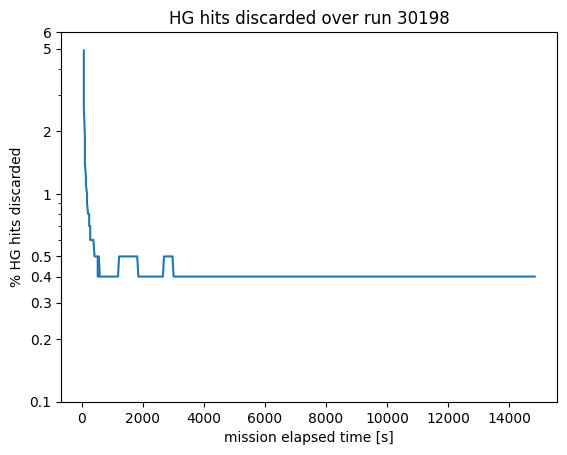

In [42]:
plt.figure()
plt.plot(met_from_hb, percent_hg_discarded)
plt.xlabel('mission elapsed time [s]')
plt.ylabel('% HG hits discarded')
plt.title('HG hits discarded over run 30198')
plt.yscale('log')

log_ticks = [0.1, 0.2, 0.3, 0.4, 0.5, 1, 2, 5, 6]  # Example values for log scale
plt.yticks(log_ticks, labels=[str(tick) for tick in log_ticks])
plt.savefig('/Users/gracetytus/Downloads/run30198_droppedHG.png')
plt.show()

In [45]:
np.average(percent_hg_discarded)

np.float64(0.4246450304259635)